# Genre Identifier

Creates a neural network that recognizes the genre of a song

feature explanation courtesy of:
https://navdeepsinghh.medium.com/identifying-the-genre-of-a-song-with-neural-networks-851db89c42f0

We compare two classifiers in this notebook:
1. Perceptron (accuracy mean: 0.9667)
2. Support vector machine with RBF kernel (accuracy mean: 0.96)

A convolutional NN is tested in a seprate notebook.

In [20]:
import librosa
import librosa.feature
import librosa.display
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import butter, lfilter
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout,  Conv1D, Conv2D, Flatten, BatchNormalization, ZeroPadding2D,  MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.utils.np_utils import to_categorical
# from keras.models import model_from_json
from keras.models import load_model
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### Inspect a single song

Here we can see clearly that using a compressor is beneficial to have similar audio signals in training and later testing.

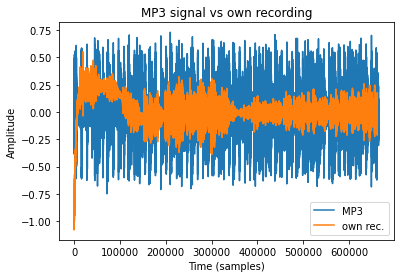

In [21]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
y, sr = librosa.load('genres/disco/disco.00000.wav')
y_rec, sr_rec = librosa.load("../../recordings/output.wav")

# Checking the audio wave and sampling rate
#y.shape, sr, sr_rec

# Plotting the wave
plt.plot(y, label='MP3')
plt.plot(y_rec, label='own rec.')
plt.title('MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

#### Filter

To alleviate this problem, we use a compressor to make signals be more similar.

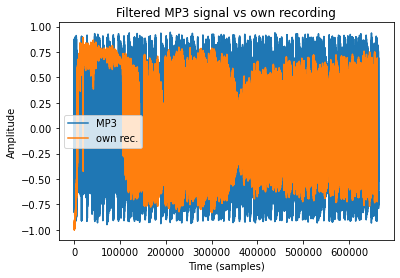

In [36]:
compressed_y = librosa.mu_compress(y, quantize=False)
# TODO: chop off in code
max_y_rec = [-1 if x < -1 else x for x in y_rec]
y_rec = np.array([1 if x > 1 else x for x in max_y_rec])
compressed_rec = librosa.mu_compress(y_rec, quantize=False)

# Plotting the filtered waves
plt.plot(compressed_y, label='MP3')
plt.plot(compressed_rec, label='own rec.')
plt.title('Filtered MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

## 1. Load the data

Load the data into one vector containg all the information. Data we use for training and testing is the GTZAN data set (https://www.tensorflow.org/datasets/catalog/gtzan).

The features we use are the normalized Mel-frequency cepstral coefficients (MFCC). These aretypically used in speech and music processing. (https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd for explanation).

Because the recording quality of our microphone is worse than the audio quality of the GTZAN data, we integrate a compressor to improve performance.

In [3]:
# bandwith filter we experimented with
def filter_f(file):
    lo, hi = 600,10000
    y, sr = librosa.load(file)
    b, a = butter(N=6, Wn=[2*lo/sr, 2*hi/sr], btype='band')
    x = lfilter(b,a,y)
    return x, sr

def compress_filter(file):
    y, sr = librosa.load(file)
    x = librosa.mu_compress(y, quantize=False)
    return x, sr

def extract_song_features(f):
    y, sr = compress_filter(f)

    # get Mel-frequency cepstral coefficients and normalize
    mfcc = librosa.feature.mfcc(y)
    mfcc /= np.amax(np.absolute(mfcc))
    return np.ndarray.flatten(mfcc)[:25000]
    
    # get melspectrogram
    #spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    #spect = librosa.power_to_db(spect, ref=np.max)
    #spect /= np.amax(np.absolute(spect))
    #return np.ndarray.flatten(spect)[:25000]

#### Load the files from the genres
For simplicity we only use classical, metal and pop.

In [4]:
# GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
GENRES = ['classical', 'metal', 'pop']
all_features = []
all_labels = []

# load all songs from the gtzan data set
for genre in GENRES:
    sound_files = glob.glob('genres/' + genre + '/*.wav')
    print('Processing %d songs in %s genre...' % (len(sound_files), genre))
    for f in sound_files:
        extracted_features = extract_song_features(f)
        all_features.append(extracted_features)
        all_labels.append(genre)

# convert labels to one-hot encoding
label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
label_row_ids = label_row_ids.astype(np.int32, copy=False)
onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))

# store features and labels
features = np.stack(all_features)
labels = onehot_labels

Processing 100 songs in classical genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...


In [5]:
# get shapes
print(np.shape(features))
print(np.shape(labels))

(300, 25000)
(300, 3)


## 2. Prepare the data set
Define procedure to split in train and test data sets.

In [6]:
def split_train_test(data, training_split=0.8, n_classes=10):
    """
    this splits according to the ration we want to split with
    """
    np.random.shuffle(data)
    split_idx = int(len(data) * training_split)
    train, test = data[:split_idx, :], data[split_idx:, :]

    #      train data,     train labels,  test data,      test labels
    return train[:, :-n_classes], train[:, -n_classes:], test[:, :-n_classes], test[:, -n_classes:]

# Perceptron

We use a Perceptron with 100 hidden units. 

In [13]:
def build_model(train):
    """
    build the model; in our case it is a perceptron with 100 layers
    """
    input_shape = np.shape(train[0])
    print(f"shape of input data: {input_shape}")
    nn_model = Sequential([
        Dense(100, input_dim=np.shape(train)[1]),
        Activation('relu'),
        Dense(len(GENRES)),
        Activation('softmax'),
    ])

    # specify which techniques you want to use for training
    nn_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    print(nn_model.summary())
    return nn_model


In [14]:
# last column has genre, turn it into unique ids
all_data = np.column_stack((features, labels))

# split into training and test data
train_input, train_labels, test_input, test_labels = split_train_test(all_data, n_classes=len(GENRES))

# build the nn model
model = build_model(train_input)
print(f"shape of input data: {np.shape(train_input)}")

shape of input data: (25000,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               2500100   
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
Total params: 2,500,403
Trainable params: 2,500,403
Non-trainable params: 0
_________________________________________________________________
None
shape of input data: (240, 25000)


In [15]:
print(all_data.shape)
print(train_input.shape)
print(train_labels.shape)
#print(train_in.shape)

(300, 25003)
(240, 25000)
(240, 3)


## 3. Run the process

Now, we train our model and evaluate it

In [16]:
# train the model
model.fit(train_input, train_labels, epochs=10, batch_size=32,
          validation_split=0.2)

# now get the performance indicators
loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))


Train on 192 samples, validate on 48 samples
Epoch 1/10
192/192 [==============================] - 1s 4ms/step - loss: 0.9124 - accuracy: 0.6771 - val_loss: 0.1794 - val_accuracy: 0.9375
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 0.9375 - val_loss: 0.0518 - val_accuracy: 0.9792
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.0927 - accuracy: 0.9531 - val_loss: 0.1815 - val_accuracy: 0.9375
Epoch 4/10
192/192 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 0.9375
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9896 - val_loss: 0.0979 - val_accuracy: 0.9583
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1308 - val_accuracy: 0.9375
Epoch 7/10
192/192 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - 

## 4. Store the classifier to use it in thinking.py

use keras for simplicity

In [28]:
# save model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


## 5. Retrieve model and test it to see if everything works

make sure you have the correct version of h5py (2.10.0). This creates warnings at one end, but was the only thing that worked for me.

In [29]:
# load model
model = load_model('model.h5')
print("Loaded model from disk")
# summarize model.
model.summary()

Loaded model from disk
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               2500100   
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 2,501,110
Trainable params: 2,501,110
Non-trainable params: 0
_________________________________________________________________


Now load a song that we recorded (or one from the dataset) to test the loaded classifier.

In [30]:
y, _ = librosa.load("../recordings/output.wav")
# get Mel-frequency cepstral coefficients and normalize
mfcc = librosa.feature.mfcc(y)
mfcc /= np.amax(np.absolute(mfcc))
own_audio = np.ndarray.flatten(mfcc)[:25000]

# evaluate loaded model on single song
test_genre = "blues"
#own_audio = extract_song_features("../recordings/output.wav")
some_audio = extract_song_features("genres/" + test_genre + "/" + test_genre + ".00000.wav")

# reshape for input
test_in = own_audio[np.newaxis,:]
test_in.shape

(1, 25000)

In [31]:
# now predict on test in
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.predict(test_in, verbose=0)

#np.set_printoptions(precision=2)
print(GENRES)
print(score[-1])

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
[3.6605616e-07 9.9999940e-01 6.3150374e-10 1.8980666e-12 4.4997513e-11
 1.8324351e-07 4.5013347e-13 5.1246114e-09 8.2647422e-12 3.0888447e-12]


In [32]:
# now output the name
max_class = score.argmax(axis=-1)
print(f"real genre: {test_genre}\npredicted genre: {GENRES[max_class[0]]}")

real genre: blues
predicted genre: classical


# Classifying genre with support vector machine

Replace the straightforward neural network with a SVM with RBF kernel.
To assess the accuracy we use a 10-fold cross-validation. The SVM performs very well.

In [6]:
# store features and labels
features = np.stack(all_features)
labels = onehot_labels

# last column has genre, turn it into unique ids
all_data = np.column_stack((features, labels))

# split into training and test data
train_input, train_labels, test_input, test_labels = split_train_test(all_data, n_classes=len(GENRES))
svm_labels = np.array([np.where(r==1)[0][0] for r in train_labels])

print(np.shape(features))
print(np.shape(labels))

(300, 25000)
(300, 3)


In [7]:
# create the svm model
def build_svm():
    clf = svm.SVC(kernel='rbf',C=1.0)
    return clf

print(np.shape(train_labels))

# train the svm
classifier = build_svm()
classifier.fit(train_input, svm_labels);

(240, 3)


In [8]:
# Predict datasetTest with svm
test_genre = "classical"

# either use studio or recorded audio
#audio = extract_song_features("../recordings/output.wav")
audio = extract_song_features("genres/" + test_genre + "/" + test_genre + ".00000.wav")

test_in = audio[np.newaxis,:]
predictY = classifier.predict(test_in)
GENRES[predictY[0]]

'classical'

### Cross Validation
adapted from https://github.com/alanwuha/cs4347-music-genre-classification

In [9]:
# pre processing
scaler = StandardScaler()
scaler.fit(features)
X = scaler.transform(features)
y = np.array([np.where(r==1)[0][0] for r in labels])
X.shape, y.shape

((300, 25000), (300,))

In [10]:
score = []
rates = []
# KFold cross validation
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X):
    # Split data to train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train
    clf = build_svm()
    clf.fit(X_train, y_train)

    # Print accuracy
    score.append(clf.score(X_test, y_test))
    print("Accuracy: \t" + str(clf.score(X_test, y_test)))

    # I make the predictions
    predicted = clf.predict(X_test)

    # I obtain the confusion matrix
    cm = confusion_matrix(y_test, predicted)

    # rate calculation
    tp_rate = []
    i = 0
    for row in cm:
        current = 0
        TP = 0
        FP = 0
        for g in row:
            if current == i:
                TP = g
            else:
                FP = FP + g
            current = current + 1
        tp_rate.append(TP / (TP + FP))
        i = i + 1
    rates.append(tp_rate)

# get the accuracies for all the genres
rates = np.round(np.mean(rates, axis=0), 3)
print("")
print("accuracy mean:", np.mean(score))
i = 0
for r in rates:
    print(GENRES[i], r)
    i = i + 1

Accuracy: 	0.9333333333333333
Accuracy: 	1.0
Accuracy: 	1.0
Accuracy: 	0.9
Accuracy: 	0.9666666666666667
Accuracy: 	0.9666666666666667
Accuracy: 	0.9
Accuracy: 	1.0
Accuracy: 	0.9666666666666667
Accuracy: 	0.9666666666666667

accuracy mean: 0.96
classical 0.949
metal 0.994
pop 0.938


#### Save the model for later

In [13]:
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)